In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import scipy.signal as sig
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from loadBeh import loadBeh
import events as eve

In [3]:
def loopMice(mice):
    """
    """
    fileList = pd.DataFrame({'Mouse':[], 'Session':[], 'Data':[], 'Behaviour':[]})
    for mus,sess in mice:
        dataPath = "J:\\Hakan Kucukdereli\\Miniscope_Behaviour_MPIN\\" + str(mus) + "_FR1_Test\\Filtered_32-bit_2X2\\ICs_" + str(sess) + "\\M" + str(mus) + "_recording_ICs.csv"
        behPath = "J:\\Hakan Kucukdereli\\Miniscope_Behaviour_MPIN\\" + str(mus) + "_FR1_Behaviour\\" + str(mus) + "_FR1_Behaviour.csv"
        musList = pd.DataFrame({ 'Mouse' : mus, 'Session' : sess, 'Data' : dataPath, 'Behaviour' : behPath }, index=[mus], dtype=object)
        fileList = fileList.append(musList)
    
    return fileList

In [4]:
def loadData(mice):
    """
        Gets the names of files of all the mice and returns it as a list.
        Input: (<mouse tag>, <session #>)
    """
    # Get the file names
    fileList = loopMice(mice)

    # Load the data
    dataList = {}
    for mus, sess in mice:
        data = pd.read_csv(fileList['Data'].loc[mus], delimiter= ",", skip_blank_lines= True, error_bad_lines= False)

        # Organize the data a little bit
        # Get the frame rate of the recording
        ##fs = data['Time (s)'].iloc[1] - data['Time (s)'].iloc[0]
        # Rearrange the time axis and set the index
        data['Time (s)'] = np.arange(0.00, len(data.index)*fs, fs)
        data = data.set_index(data['Time (s)'])

        dataList[mus] = data.drop('Time (s)', 1)

    return dataList

In [5]:
def getBeh(mice, behList):
    """
    """
    eventList = {}
    hitsList = {}
    missesList = {}
    for mus, sess in mice:
        eventList[mus], hitsList[mus], missesList[mus] = loadBeh(behList[mus])
    
    return eventList, hitsList, missesList

In [6]:
def dFFcalc(mice, dataList, average=0):
    """
        Calculate the dFF for the given dataframe.
        Input: (<mouse tag>, <session #>), dataList
    """
    dFFList = {}
    for mus, sess in mice:
        data = dataList[mus]
        minPoint = data.idxmin(axis= 0)
        
        dFF = pd.DataFrame()
        for i, m in enumerate(minPoint):
            F0 = data[data.columns[i]][m-2.50 : m+2.50].mean(axis= 0)
            dFF[data.columns[i]] = (data[data.columns[i]] - F0) / F0 * 100
        
        # Filter first
        dFF = dFF.rolling(window= average).mean()
        
        # Put each dataframe into the dict
        dFFList[mus] = dFF
    
    return dFFList

In [7]:
def markTrials(mice, base, duration, eventType, trials, dff= True, baseline=False):
    """
    """
    # Load the data
    dataList = loadData(mice)
    if dff:
        dataList = dFFcalc(mice, dataList, average= 5)
    
    # Load the events
    fileList = loopMice(mice)
    eventList, hitsList, missesList = getBeh(mice, fileList['Behaviour'])
    
    eventsData = pd.DataFrame()
    for mus, sess in mice:
        
        # Find the events
        eventTimes = np.array([])
        for i, event in enumerate(eventList[mus][eventType].dropna()):
            ind, nearest = eve.find_nearest(dataList[mus].index.values, event)
            eventTimes = np.append(eventTimes, nearest)
        
        fs = dataList[mus].index[1] - dataList[mus].index[0]
        for col in dataList[mus].columns:
            if not col == 'Time (s)':
                data = dataList[mus][col]
                for i, event in enumerate(eventTimes[trials[0]-1:trials[1]]):
                    slicedData = pd.DataFrame()
                    
                    if baseline:
                        basedFF = data.loc[event-baseline+0.0001:event+0.0001].mean()
                    elif not baseline:
                        basedFF = 0
                        
                    slicedData['Fluoro'] = data.loc[event-base+0.0001:event+duration+0.0001].values - basedFF
                    slicedData['Cell'] = col
                    slicedData['Event'] = i+1
                    slicedData['New_Time'] = np.arange(-base,duration,fs)

                    eventsData = eventsData.append(slicedData)
                    
    print "\n", len(mice), " mice were loaded."
    for mus, sess in mice:
        print "Mouse number", mus, " had ", hitsList[mus], " total rewards."
        
    if baseline:
        print "\nBaseline was set", baseline, "sec before the event."
    elif not baseline:
        print "\nTraces were not baselined."

    return eventsData

In [8]:
# Start running the analysis
mice = [(8404, 6), (8857, 2), (8864, 1)]
fileList = loopMice(mice)

In [9]:
fs = 0.05
base = 5.0
duration = 25.0
eventType = 'Eat_Start'
trials=[1,12]

In [10]:
eventsData = markTrials(mice, base, duration, eventType, trials=trials, baseline=base)

# Calculate the mean and sem
mean=eventsData.pivot_table(index=['Event', 'Cell'], columns='New_Time').mean()
sem=eventsData.pivot_table(index=['Event', 'Cell'], columns='New_Time').sem()
time = np.arange(-base,duration,fs)

Number of successful rewards received (hits):  15
Number of missed rewards (misses):  2
Number of successful rewards received (hits):  17
Number of missed rewards (misses):  1
Number of successful rewards received (hits):  13
Number of missed rewards (misses):  2

3  mice were loaded.
Mouse number 8404  had  15  total rewards.
Mouse number 8857  had  17  total rewards.
Mouse number 8864  had  13  total rewards.

Baseline was set 5.0 sec before the event.


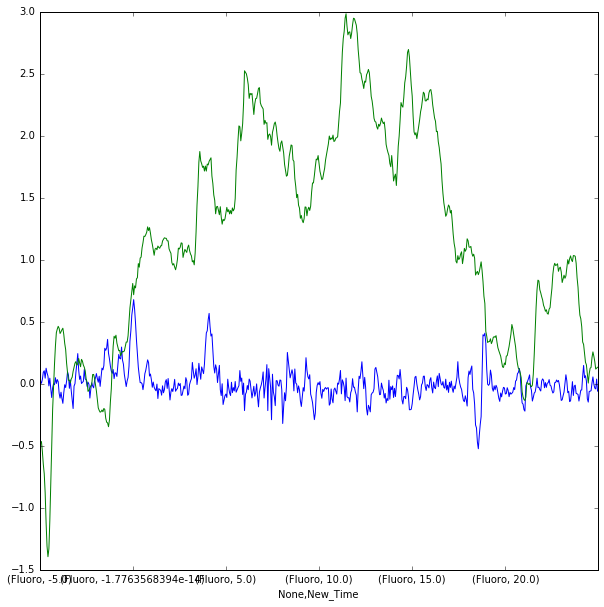

In [41]:
eventsData.pivot_table(index=['Cell', 'Event'], columns='New_Time').loc['M8404_recording_ICs2 (Fluorescence (au))'].diff(axis=1).loc[1].plot(figsize=(10,10))
eventsData.pivot_table(index=['Cell', 'Event'], columns='New_Time').loc['M8404_recording_ICs2 (Fluorescence (au))'].loc[12].plot()